# Exercise 3
## Bias/variance tradeoff in regression
### G. Bontempi






Let us consider the dependency where the conditional distribution of ${\mathbf y}$ is
$$
{\mathbf y}= \sin(2 \pi x_1 x_2 x_3)+{\mathbf w}
$$
and ${\mathbf w}\sim N(0,\sigma^2)$ with $\sigma=0.25$.
Suppose that ${\mathbf x} \in {\mathbb R}^3$
has a 3D normal distribution with an identity covariance matrix.
The number of observed input/output samples is $N=100$.

Consider the following families of learners:

* constant model returning always zero
* constant model $h(x)=\beta_0$
* linear model $h(x)=x^T \beta$
* $K$ nearest neighbour for $K=1,3,5,7$ where the distance is Euclidean

Implement for each learner above a function

In [1]:

def learner(Xtr, Ytr, Xts):
    ####
    # Xtr [N,n] input training set
    # Ytr [N,1] output training set
    # Xts [Nts,n] input test set
    return Yhat



which returns a vector $[N_{ts},1]$ of predictions for the given input test set.

By using Monte Carlo simulation ($S=100$ runs) and by using a fixed-input test set of size $N_{ts}=1000$

* compute the average squared bias of all the learners,
* compute the average variance of all the learners,
* check the relation between squared bias, variance, noise variance and MISE
* define what is the best learner in terms of $\mbox{MISE}$,
* discuss the results: is always the most complex learner the best one?
* Consider a single dataset of size $N$ and by using Leave-One-Out find what would be the best learner according to $\widehat{\mbox{MISE}}_{loo}$




## Learners

In [2]:


import numpy as np

def zeroL(Xtr, Ytr, Xts):
    Nts = Xts.shape[0]
    Yhat = np.zeros(Nts)
    return Yhat

def constantL(Xtr, Ytr, Xts):
    Nts = Xts.shape[0]
    Yhat = np.full(Nts, np.mean(Ytr))
    return Yhat

def linearL(Xtr, Ytr, Xts):
    Nts = Xts.shape[0]
    N = Xtr.shape[0]
    # Add a column of ones for the intercept
    XXtr = np.hstack((np.ones((N, 1)), Xtr))
    XXts = np.hstack((np.ones((Nts, 1)), Xts))
    # Compute beta hat using the normal equation
    betahat = np.linalg.inv(XXtr.T @ XXtr) @ XXtr.T @ Ytr
    Yhat = XXts @ betahat
    return Yhat

def knnL(Xtr, Ytr, Xts, K=1):
    Nts = Xts.shape[0]
    N = Xtr.shape[0]
    Yhat = np.zeros(Nts)
    for i in range(Nts):
        # Compute the squared Euclidean distance
        differences = Xtr - Xts[i, :]
        distances = np.mean(differences ** 2, axis=1)
        # Get the indices of the K smallest distances
        iD = np.argsort(distances)[:K]
        Yhat[i] = np.mean(Ytr[iD])
    return Yhat




## Theoretical setting: Monte Carlo approximation of MISE

Now let us consider a *purely theoretical* setting, i.e. where we have access to ALL the information concerning the generating process underlying the observational data. Note this is NOT the case in realistic settings.


Let us use Monte Carlo simulation to approximate numerically the Mean Integrated Squared Errors of the four learners $h$
$$\mbox{MISE}=E_{{\mathbf x}}[ \mbox{MSE}(\mathbf x)]$$
where
$$\mbox{MSE}( x)=E_{{\mathbf D}_N, {\mathbf y}} [({\mathbf y}-h(x,{\mathbf \alpha}_N))^2]$$ 
is the Mean Squared Error for a give input $x$.

Note that
* $N$ is the number of training observations and is fixed
* $Nts$ is the number of test observations to approximate the expectation  $E_{{\mathbf y}}$ over all possible test values. The larger this value in the simulation, the better is the approximation of this expectation
* $S$ is the number of Monte Carlo trials to approximate the expectation  $E_{{\mathbf D}_N}$ over all possible training sets of size $N$. For each trial, we generate a new training set of size $N$ and a new test of size $Nts$. The larger this value in the simulation, the better is the approximation of this expectation
* the data generation (and the Monte Carlo simulaiton) is possible since we know all about the data generating process
$$
{\mathbf y}= \sin(2 \pi x_1 x_2 x_3)+{\mathbf w}
$$

In [3]:
# chunk 3

import numpy as np

np.random.seed(0)
N = 100  # number of samples
Nts = 1000
n = 3
S = 100  # number of MC trials
models = ["zero", "const", "lin", "1NN", "3NN", "5NN", "7NN"]
sdw = 0.25  # standard deviation of noise
M = len(models)
Xts = np.random.randn(Nts, n)

fts = np.sin(2 * np.pi * Xts[:, 0] * Xts[:, 1] * Xts[:, 2])
YH = np.zeros((S, Nts, M))
Ytrue = []

for s in range(S):
    Yts = np.sin(2 * np.pi * Xts[:, 0] * Xts[:, 1] * Xts[:, 2]) + np.random.normal(0, sdw, Nts)
    Xtr = np.random.randn(N, n)
    Ytr = np.sin(2 * np.pi * Xtr[:, 0] * Xtr[:, 1] * Xtr[:, 2]) + np.random.normal(0, sdw, N)
    
    Yhats1 = zeroL(Xtr, Ytr, Xts)
    YH[s, :, 0] = Yhats1
    
    Yhats2 = constantL(Xtr, Ytr, Xts)
    YH[s, :, 1] = Yhats2
    
    Yhats3 = linearL(Xtr, Ytr, Xts)
    YH[s, :, 2] = Yhats3
    
    Yhats4 = knnL(Xtr, Ytr, Xts, K=1)
    YH[s, :, 3] = Yhats4
    
    Yhats5 = knnL(Xtr, Ytr, Xts, K=3)
    YH[s, :, 4] = Yhats5
    
    Yhats6 = knnL(Xtr, Ytr, Xts, K=5)
    YH[s, :, 5] = Yhats6
    
    Yhats7 = knnL(Xtr, Ytr, Xts, K=7)
    YH[s, :, 6] = Yhats7
    
    Ytrue.append(Yts)
    




Now let us check the identity 

$$\mbox{MISE}= E_{\mathbf x} \left[ B^2(\mathbf x) + \mbox{Var}(\mathbf x) + \sigma^2_{\mathbf w} \right] $$

where 
* $$B(x)=f(x)-h(x,{\boldsymbol \alpha}_N)$$ is the bias of the learner $h(x,{\mathbf \alpha}_N)$ trained with $n$ observations in the input $x$
* $$\mbox{Var}(x)=E_{{\mathbf D}_N} [(h(x,{\mathbf \alpha}_N) -E [h(x,{\mathbf \alpha}_N)])^2] $$ is the variance of the learner $h(x,{\mathbf \alpha}_N)$ in the input $x$
* $\sigma^2_{\mathbf w}$ is the variance of the noise term $\mathbf w$

In [6]:
Ytrue = np.vstack(Ytrue)

mYH = np.mean(YH, axis=0)
vYH = np.var(YH, axis=0)

SBiases = np.mean((fts.reshape(-1,1)@np.ones((1,mYH.shape[1])) - mYH) ** 2, axis=0)
Variances = np.mean(vYH, axis=0)

MSE=[]
SBiases=[]
for m in np.arange(M):
    SBiases.append(np.mean((fts - mYH[:,m]) ** 2, axis=0))
    MSE.append(np.mean((Ytrue - YH[:,:,m]) ** 2, axis=(0, 1)))

print('\n MISE=',np.round(MSE,2))
print('Squared bias+variance +noise=',np.round(SBiases + Variances + sdw ** 2,2))



 MISE= [0.46 0.47 0.48 0.73 0.52 0.49 0.48]
Squared bias+variance +noise= [0.46 0.47 0.48 0.73 0.52 0.49 0.48]


Here above we checked the identity between MISE, squared bias and variance. Note that all those terms have been approximated numerically by using Monte Carlo simulation.

Let us now plot for the seven learner $h$ their MISE, bias and variance. 


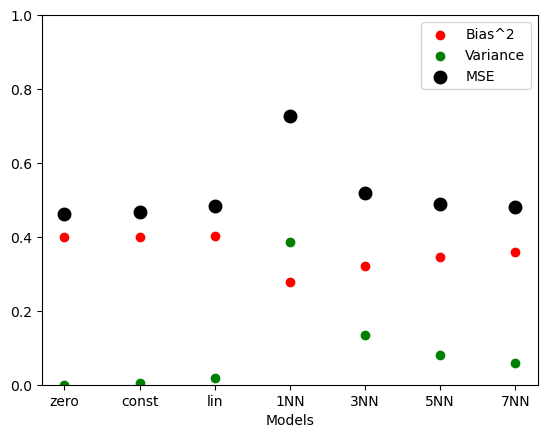

bestModel= zero


In [5]:


import matplotlib.pyplot as plt

plt.figure()
plt.scatter(range(M), SBiases, color="red", label="Bias^2")
plt.scatter(range(M), Variances, color="green", label="Variance")
plt.scatter(range(M), MSE, color="black", label="MSE", linewidth=4)
plt.xticks(range(M), models)
plt.ylim(0, 1)
plt.xlabel("Models")
plt.ylabel("")
plt.legend(loc="upper right")
plt.show()

bestModel = models[np.argmin(MSE)]
print('bestModel=',bestModel)

The plot shows that the first three learner have low variance but  large bias.
For the KNN learners it appears that the bias (variance) increases (decreases) by increasing $K$.

The best model in terms of MSE is _bestModel_ since it shows the best tradeoff in terms of bias and variance. As you see it is not always the most sophisticated learning model which allows the best generalization!


## Realistic setting: Leave-one-out estimation of the MISE

Here we are in a *realistic* configuration, i.e. we consider only one observed data set.

We cannot make anymore the Monte Carlo simulation made above. Still, we may have recourse to the Leave-One-Out validation strategy to compute  $\widehat{\mbox{MISE}}_{loo}$ which is the LOO estimation of the generalization accuracy of each model. Then we can proceed to the model selection.


Here below, I generate a single dataset and proceed by Leave-One-Out

In [22]:
np.random.seed(0)
Xtr = np.random.randn(N, n)
Ytr = np.sin(2 * np.pi * Xtr[:, 0] * Xtr[:, 1] * Xtr[:, 2]) + np.random.normal(0, sdw, N)
Eloo = np.zeros((N, M))
for i in np.arange(N):
    Xtri = np.delete(Xtr, i, axis=0)
    Ytri = np.delete(Ytr, i)
    Xtsi = Xtr[i, :].reshape(1, -1)
    Ytsi=Ytr[i]
    
    Yhats1 = zeroL(Xtri, Ytri, Xtsi)[0]
    Eloo[i, 0] = (Ytsi-Yhats1)**2
    
    Yhats2 = constantL(Xtri, Ytri, Xtsi)[0]
    Eloo[i, 1] = (Ytsi-Yhats2)**2
    
    Yhats3 = linearL(Xtri, Ytri, Xtsi)[0]
    Eloo[i, 2] = (Ytsi-Yhats3)**2
    
    Yhats4 = knnL(Xtri, Ytri, Xtsi, K=1)[0]
    Eloo[i, 3] = (Ytsi-Yhats4)**2
    
    Yhats5 = knnL(Xtri, Ytri, Xtsi, K=3)[0]
    Eloo[i, 4] = (Ytsi-Yhats5)**2
    
    Yhats6 = knnL(Xtri, Ytri, Xtsi, K=5)[0]
    Eloo[i, 5] = (Ytsi-Yhats6)**2
    
    Yhats7 = knnL(Xtri, Ytri, Xtsi, K=7)[0]
    Eloo[i, 6] = (Ytsi-Yhats7)**2

MISEloo=np.mean(Eloo,axis=0)

print('MISEloo=',MISEloo)

MISEloo= [0.46915697 0.46382067 0.49438461 0.82137377 0.55745295 0.49751498
 0.50294196]


Now we show in the same figure both the *real* ${\mbox{MISE}}$ and the $\widehat{\mbox{MISE}}_{loo}$ estimated by leave-one-out.

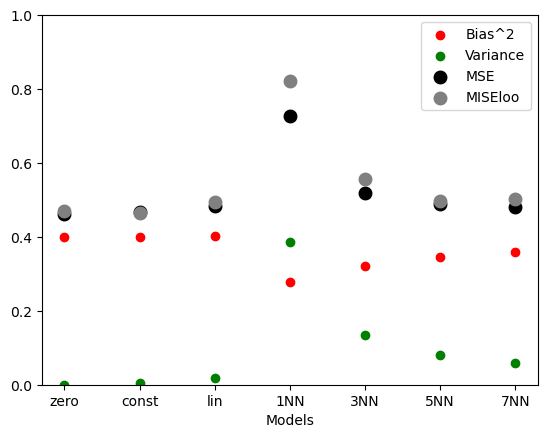

bestModel (Winner-takes all) according to LOO= const


In [23]:
plt.figure()
plt.scatter(range(M), SBiases, color="red", label="Bias^2")
plt.scatter(range(M), Variances, color="green", label="Variance")
plt.scatter(range(M), MSE, color="black", label="MSE", linewidth=4)
plt.scatter(range(M), MISEloo, color="grey", label="MISEloo", linewidth=4)

plt.xticks(range(M), models)
plt.ylim(0, 1)
plt.xlabel("Models")
plt.ylabel("")
plt.legend(loc="upper right")
plt.show()

bestModel = models[np.argmin(MISEloo)]
print('bestModel (Winner-takes all) according to LOO=',bestModel)